# Pricing European Options

## Student ID:
1. 201701073 - Purvil Mehta
2. 201701074 - Bhargey Mehta
3. 201701435 - Ruchit Shah
4. 201701438 - Niharika Dalsania

## Paper Reference

1. [Quantum computational finance: Monte Carlo pricing of financial derivatives](https://arxiv.org/pdf/1805.00109.pdf) 
2. [Option Pricing using Quantum Computers](https://arxiv.org/pdf/1905.02666.pdf)



# Library Initialisation 

In [ ]:
!pip install qiskit
!pip install pylatexenc

In [ ]:
import matplotlib.pyplot as plt
from qiskit.finance.applications import EuropeanCallExpectedValue
import numpy as np
from qiskit import *
from qiskit.quantum_info import *
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation, AmplitudeEstimation
from qiskit.circuit.library import LogNormalDistribution, LinearAmplitudeFunction, NormalDistribution
from typing import Tuple, List, Union, Optional
import numpy as np
from qiskit.circuit import QuantumCircuit
from qiskit.visualization import plot_bloch_multivector,plot_histogram

# Utility Functions

In [ ]:
# Get algorithm G or A from probability distribution functions
def getuncertainty_model(num_uncertainty_qubits, dist, mu, sigma, low, high):
  if (dist == 'lognorm'):
    uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))
  elif (dist == 'poisson'):
    uncertainty_model = poissonDistribution(num_uncertainty_qubits, mu=mu, bounds=(low, high))
  else:
    uncertainty_model = NormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

  # Plotting the distributions
  x = uncertainty_model.values
  y = uncertainty_model.probabilities
  plt.bar(x, y, width=0.2)
  plt.xticks(x, size=15, rotation=90)
  plt.yticks(size=15)
  plt.grid()
  plt.xlabel('Spot Price at T', size=15)
  plt.ylabel('Probability', size=15)
  plt.show()
  return uncertainty_model
 
# A followed by R (F operator which generates the |x>). 
def getCircuit(uncertainty_model, strike_price, c_approx, low, high,
               breakpoints, slopes, offsets, f_min, f_max):
  
  european_call_objective = LinearAmplitudeFunction(
      num_uncertainty_qubits, 
      slopes,
      offsets,
      domain=(low, high),
      image=(f_min, f_max),
      breakpoints=breakpoints,
      rescaling_factor=c_approx
  )

  # Circuit Initialisation
  num_qubits = european_call_objective.num_qubits
  european_call = QuantumCircuit(num_qubits)
  european_call.append(uncertainty_model, range(num_uncertainty_qubits))
  european_call.append(european_call_objective, range(num_qubits))

  return european_call, european_call_objective

def get_exact_values(uncertainty_model, x, y, title):

  # plot exact payoff function 
  plt.plot(x, y, 'ro-')
  plt.grid()
  plt.title('Payoff for' + title)
  plt.xlabel('Spot Price')
  plt.ylabel('Payoff')
  plt.xticks(x, rotation=90)
  plt.show()
 
  exact_value = np.dot(uncertainty_model.probabilities, y)
  print('exact expected value:\t%.4f' % exact_value)
  return exact_value

In [ ]:
# Sub-routine to estimate the prices 
def estimatePrice(epsilon, alpha, shots, european, european_objective):
  ae = IterativeAmplitudeEstimation(epsilon=epsilon, alpha=alpha, 
                                  state_preparation=european,
                                  objective_qubits=[3], 
                                  post_processing=european_objective.post_processing)

  result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=shots)
  conf_int = np.array(result['confidence_interval'])
  # print('Exact value:        \t%.4f' % exact_value)
  print('Estimated value:    \t%.4f' % (result['estimation']))
  print('Confidence interval:\t[%.4f, %.4f]' % tuple(conf_int))
  return result['estimation']

# Custom Phase Estimation Circuit

## U gate

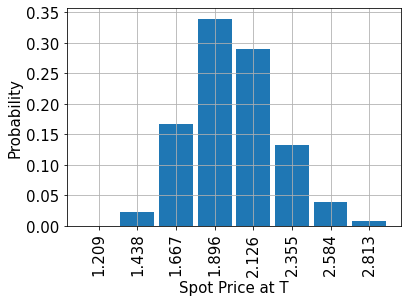

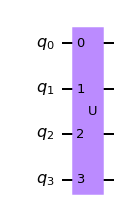

In [ ]:
num_uncertainty_qubits = 3

# # parameters for considered random distribution
S = 2       
vol = 0.4    
r = 0.05     
T = 40 / 365 
strike_price = 2

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)
low  = np.maximum(0, mean - 3*stddev)
high = mean + 3*stddev
uncertainty_model = getuncertainty_model(3, 'lognorm', mu, sigma, low, high)
european_call, european_call_objective = getCircuit(uncertainty_model, strike_price, 0.25, low, high,
                                                    [low, strike_price], [0,1], [0,0], 0, high - strike_price)

backend = Aer.get_backend('statevector_simulator')
final_state = execute(european_call,backend).result().get_statevector()

X = quantum_info.Statevector(final_state[:16])
dummyGate = X.to_operator()

U = quantum_info.Operator(np.identity(16)) - 2*dummyGate
U = extensions.UnitaryGate(U)

UGate = QuantumCircuit(4)
UGate.unitary(U, [0,1,2,3], label='U')
UGate.draw(output = 'mpl')

## V gate

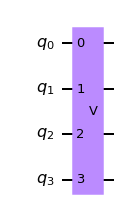

In [ ]:
identity = np.identity(2**4,dtype = float)
lower_identity = 2*np.identity(2**3,dtype = float)

vector = np.array([[0,0],[0,1]])
Varray = identity - np.kron(vector, lower_identity)
V = extensions.UnitaryGate(Varray)

VGate = QuantumCircuit(4)
VGate.unitary(V, [0,1,2,3], label='V')
VGate.draw(output = 'mpl')

## S Gate

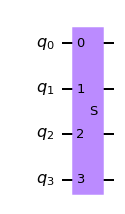

In [ ]:
identity = np.identity(2**4,dtype = float)
d = dummyGate.data
Sarray = identity - 2*np.matmul(np.matmul(Operator(V).data,d),Operator(V).data)
S = extensions.UnitaryGate(Sarray)

SGate = QuantumCircuit(4)
SGate.unitary(S, [0,1,2,3], label='S')
SGate.draw(output = 'mpl')

## Q Gate

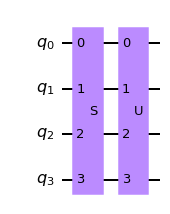

In [ ]:
QGate = QuantumCircuit(4)
QGate.unitary(S,[0,1,2,3], label = 'S')
QGate.unitary(U,[0,1,2,3], label = 'U')
backend = Aer.get_backend('unitary_simulator')
Q = execute(QGate, backend).result().get_unitary(QGate, decimals=3)
Q = extensions.UnitaryGate(Q)
#Q = QGate.to_gate()
QGate.draw(output = 'mpl')

## Final Circuit

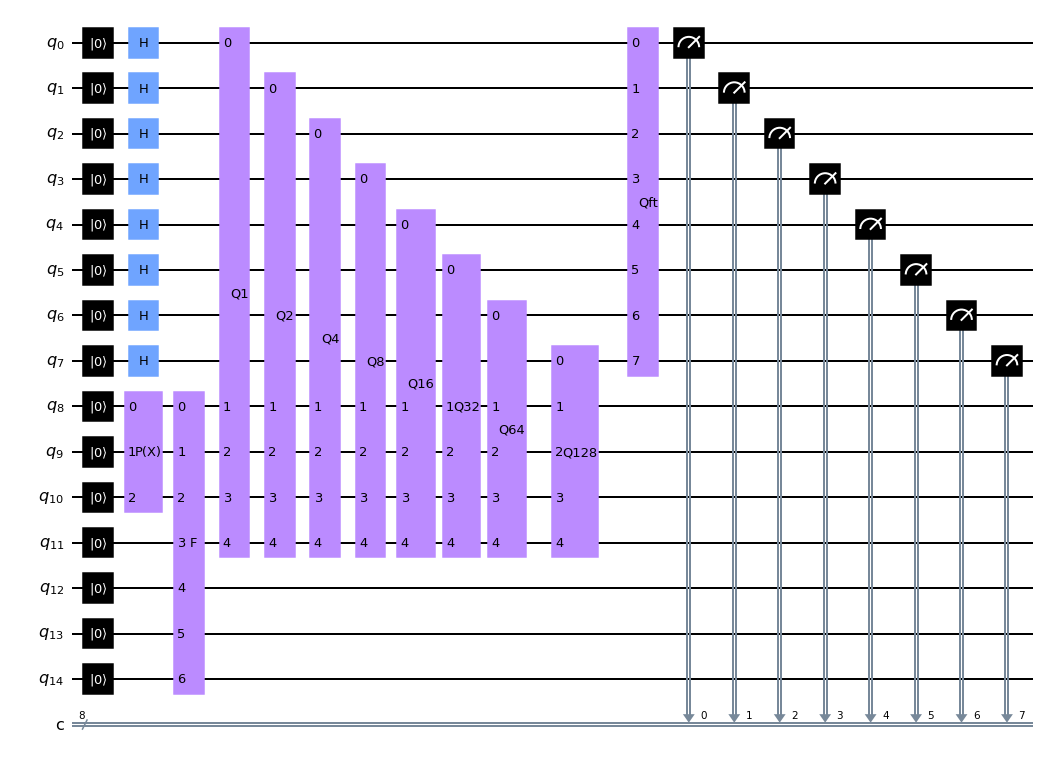

In [ ]:
#uncertainty_model = getuncertainty_model(3, 'lognorm', mu, sigma, low, high)
#european_call, european_call_objective = getCircuit(uncertainty_model, strike_price, 0.25, low, high,
#                                                   [low, strike_price], [0,1], [0,0], 0, high - strike_price)

num_qubits = european_call_objective.num_qubits
acc_bits = 8

qr = QuantumRegister(acc_bits+num_qubits, 'q')
cr = ClassicalRegister(acc_bits , 'c')
QMC = QuantumCircuit(qr,cr) 
QMC.reset(qr)

QMC.append(uncertainty_model, range(acc_bits, acc_bits+num_uncertainty_qubits))
QMC.append(european_call_objective, range(acc_bits, acc_bits+num_qubits))

for i in range(acc_bits):
  QMC.h(i)

QUnitary = Operator(Q).data
identity = np.identity(2**4, dtype = float)
CQarray = np.kron(QUnitary, [[0,0],[0,1]]) + np.kron(identity, [[1,0],[0,0]])
CQ = extensions.UnitaryGate(CQarray)
QMC.draw()

for i in range(acc_bits):
  CQs = np.linalg.matrix_power(Operator(CQ).data, 2**(i))
  QMC.unitary(CQs,[i]+list(range(acc_bits, acc_bits+num_uncertainty_qubits+1)),
              label = 'Q'+str(2**(i)))

QMC.append(qiskit.circuit.library.QFT(acc_bits,do_swaps=False, inverse=True),
           list(range(acc_bits)))
QMC.measure(qr[:acc_bits], cr[:])
# QMC.measure(qr[11], cr[0])
QMC.draw(output = 'mpl')

In [ ]:
# num_qubits = european_call_objective.num_qubits
# acc_bits = 8

# qr = QuantumRegister(num_qubits + acc_bits, 'q')
# cr = ClassicalRegister(acc_bits +1, 'c')
# QMC = QuantumCircuit(qr,cr) 
# QMC.reset(qr)

# QMC.append(uncertainty_model, range(num_uncertainty_qubits))
# QMC.append(european_call_objective, range(num_qubits))

# for i in range(num_qubits ,num_qubits +acc_bits):
#   QMC.h(i)

# QUnitary = Operator(Q).data
# identity = np.identity(2**7, dtype = float)
# CQarray = np.kron([[0,0],[0,1]],QUnitary) + np.kron([[1,0],[0,0]],identity)
# CQ = extensions.UnitaryGate(CQarray)

# for i in range(acc_bits):
#   CQs = np.linalg.matrix_power(Operator(CQ).data, 2**(i))
#   QMC.unitary(CQs,list(range(num_qubits)) + [num_qubits+i], label = 'Q'+str(2**(i)))

# # QCircuit = QuantumCircuit(7)
# # QCircuit.unitary(Q, [0,1,2,3,4,5,6], label='QC')
# # print(QCircuit.draw())
# # custom = QCircuit.to_gate().control()
# # CQ2 = np.linalg.matrix_power(Operator(CQ).data, 2)
# # CQ4 = np.linalg.matrix_power(Operator(CQ).data, 4)
# # QMC.unitary(CQ2,[0,1,2,3,4,5,6,8], label = 'Q2')
# # QMC.unitary(CQ4,[0,1,2,3,4,5,6,9], label = 'Q4')

# QMC.append(qiskit.circuit.library.QFT(acc_bits,do_swaps=False, inverse=True), list(range(num_qubits,num_qubits+acc_bits)))
# QMC.measure(qr[num_qubits:],cr[1:])
# QMC.measure(qr[3],cr[0])
# QMC.draw(output = 'mpl')

{'11101001': 4764, '00010110': 40, '10010110': 4801, '01010110': 90, '01111001': 2, '01101001': 83, '11010110': 23, '00011001': 47, '11100110': 12, '00101001': 12, '01011001': 9, '10011001': 19, '10000101': 2, '11110110': 2, '11001001': 4, '10101001': 19, '11111000': 1, '10111001': 1, '10000110': 1, '00110110': 9, '10111010': 1, '11000110': 1, '01100110': 6, '01001110': 1, '00000101': 3, '10110110': 3, '11010001': 1, '00111001': 2, '01010001': 1, '10100110': 4, '10001001': 1, '11011001': 5, '00100110': 3, '11110101': 2, '10001110': 1, '00001001': 2, '11001000': 1, '00000110': 1, '01001001': 4, '01110110': 1, '00001101': 1, '11110001': 1, '00001110': 2, '00001111': 1, '01101110': 1, '00100001': 1, '01101010': 1, '10110001': 1, '11011010': 1, '01010101': 1, '01110001': 1, '11001010': 1, '10110011': 1, '00101000': 1}


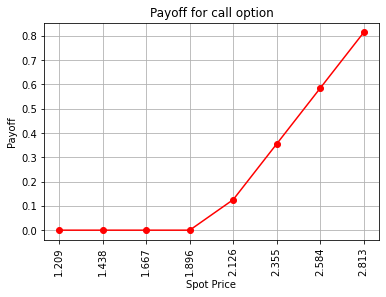

exact expected value:	0.1133
0.11327045100321792
10010110 0.19724447929783723 4801
11101001 0.42967088033357537 4764
01010110 0.0680135719392066 90
01101001 0.1002313654460475 83


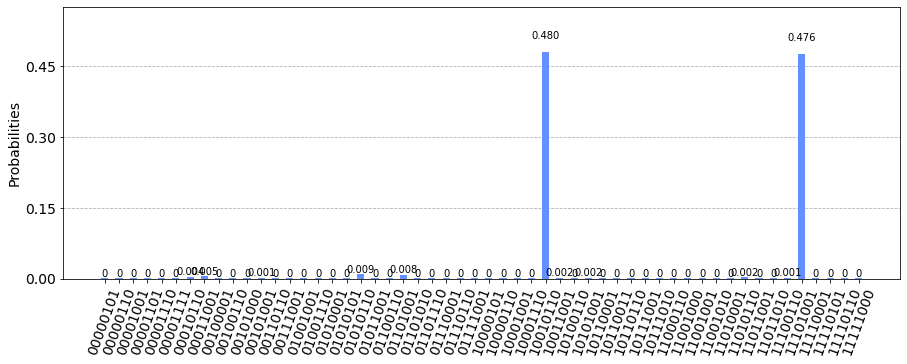

In [ ]:
import math
backend = BasicAer.get_backend('qasm_simulator')
shots = 10000
results = execute(QMC, backend=backend, shots=shots).result()
ans = results.get_counts()
# plot_histogram(answer)
print(ans)
good_Ans = {}
mus = []
for k in ans:
  if True:
    actual = k
    good_Ans[actual] = ans[k]
    x = int(actual, 2) / (2**acc_bits)
    mu = (1 - math.cos(0.5*np.pi*x))/2
    mus.append((actual, mu, ans[k]))

mus.sort(key=lambda x: x[2], reverse=True)
y = np.maximum(0, uncertainty_model.values - strike_price)
exact_value = get_exact_values(uncertainty_model, uncertainty_model.values, y, ' call option')
print(exact_value)
for mu in mus[:4]:
    print(*mu)
plot_histogram(good_Ans,figsize=(15,5))

# Log Normal Distribution

## Parameter

In [ ]:
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2       
vol = 0.4    
r = 0.05     
T = 40 / 365 
strike_price = 1.896

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)
low  = np.maximum(0, mean - 3*stddev)
high = mean + 3*stddev

## Call Option

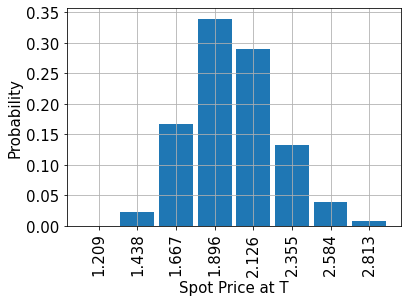

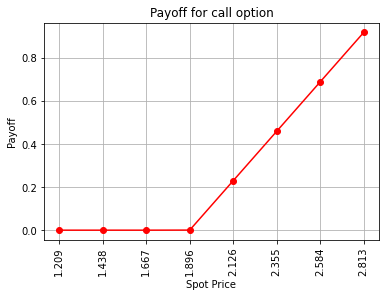

exact expected value:	0.1623
Estimated value:    	0.1668
Confidence interval:	[0.1542, 0.1793]


0.16676733121267362

In [ ]:
uncertainty_model = getuncertainty_model(3, 'lognorm', mu, sigma, low, high)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
exact_value = get_exact_values(uncertainty_model, x, y, ' call option')
european_call, european_call_objective = getCircuit(uncertainty_model, strike_price, 0.25, low, high,
                                                    [low, strike_price], [0,1], [0,0], 0, high - strike_price)

# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

estimatePrice(epsilon, alpha, 500, european_call, european_call_objective)

## Put Option

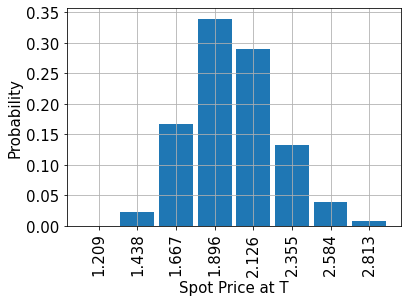

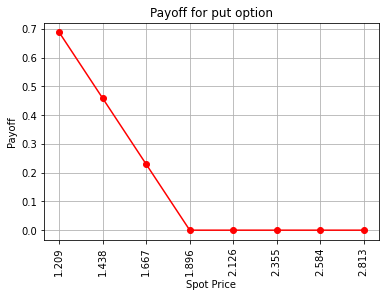

exact expected value:	0.0490
Estimated value:    	0.0563
Confidence interval:	[0.0552, 0.0574]


0.05629542486555462

In [ ]:
uncertainty_model = getuncertainty_model(3, 'lognorm', mu, sigma, low, high)
x = uncertainty_model.values
y = np.maximum(0, strike_price - x)
exact_value = get_exact_values(uncertainty_model, x, y, ' put option')
european_put, european_put_objective = getCircuit(uncertainty_model, strike_price, 0.25, low, high,
                                [low, strike_price], [-1,0], [strike_price-low,0], 0, strike_price - low)
estimatePrice(0.001, alpha, 500, european_put, european_put_objective)

# Poisson Distribution

## PMF

In [ ]:
class poissonDistribution(QuantumCircuit):
    
    def __init__(self,
                 num_qubits: Union[int, List[int]],
                 mu: Optional[Union[float, List[float]]] = None,
                 bounds: Optional[Union[Tuple[float, float], List[Tuple[float, float]]]] = None,
                 upto_diag: bool = False,
                 name: str = 'P(X)') -> None:

        # set default arguments
        dim = 1 if isinstance(num_qubits, int) else len(num_qubits)
        if mu is None:
            mu = 0 if dim == 1 else [0] * dim

        if bounds is None:
            bounds = (0, 1) if dim == 1 else [(0, 1)] * dim

        if not isinstance(num_qubits, list):  # univariate case
            super().__init__(num_qubits, name=name)

            x = np.linspace(bounds[0], bounds[1], num=2**num_qubits)  # evaluation points
        else:  # multivariate case
            super().__init__(sum(num_qubits), name=name)

            # compute the evaluation points using numpy's meshgrid
            # indexing 'ij' yields the "column-based" indexing
            meshgrid = np.meshgrid(*[np.linspace(bound[0], bound[1], num=2**num_qubits[i])
                                     for i, bound in enumerate(bounds)], indexing='ij')
            # flatten into a list of points
            x = list(zip(*[grid.flatten() for grid in meshgrid]))

        # compute the normalized, truncated probabilities
        probabilities = []
        from scipy.stats import poisson

        for x_i in x:
            if np.min(x_i) > 0:
                probability = poisson.pmf(x_i,mu) 
            else:
                probability = 0
            probabilities += [probability]

        normalized_probabilities = probabilities / np.sum(probabilities)

        # store as properties
        self._values = x
        self._probabilities = normalized_probabilities
        self._bounds = bounds

        if upto_diag:
            self.isometry(np.sqrt(normalized_probabilities), self.qubits, None)
        else:
            from qiskit.extensions import Initialize  # pylint: disable=cyclic-import
            initialize = Initialize(np.sqrt(normalized_probabilities))
            circuit = initialize.gates_to_uncompute().inverse()
            self.compose(circuit, inplace=True)

    @property
    def values(self) -> np.ndarray:
        return self._values

    @property
    def probabilities(self) -> np.ndarray:
        return self._probabilities

    @property
    def bounds(self) -> Union[Tuple[float, float], List[Tuple[float, float]]]:
        return self._bounds

## Parameter

In [ ]:
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2       
vol = 0.4     
r = 0.05     
T = 40 / 365 
strike_price = 3

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)
low  = np.maximum(0, mean - 3*stddev)
high = mean + 3*stddev

# Poisson Parameters
stddev = 2 
mu = 3
low = np.floor(low)
high = 2**num_uncertainty_qubits + low - 1

## Call Option

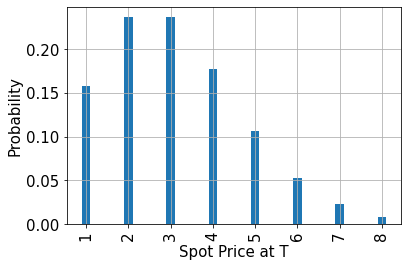

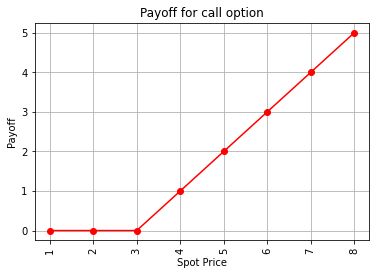

exact expected value:	0.6845
Estimated value:    	0.7183
Confidence interval:	[0.6969, 0.7396]


0.7182610381005871

In [ ]:
uncertainty_model = getuncertainty_model(3, 'poisson', mu, sigma, low, high)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
exact_value = get_exact_values(uncertainty_model, x, y, ' call option')
european_call, european_call_objective = getCircuit(uncertainty_model, strike_price, 0.25, low, high,
                                                    [low, strike_price], [0,1], [0,0], 0, high - strike_price)

estimatePrice(epsilon, alpha, 500, european_call, european_call_objective)

## Put Option

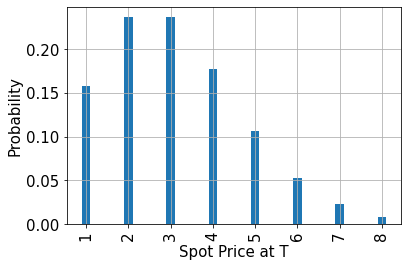

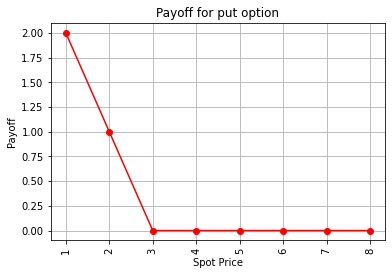

exact expected value:	0.5524
Estimated value:    	0.5661
Confidence interval:	[0.5606, 0.5717]


0.5661337283248056

In [ ]:
epsilon = 0.01
alpha = 0.05
uncertainty_model = getuncertainty_model(3, 'poisson', mu, sigma, low, high)
x = uncertainty_model.values
y = np.maximum(0, strike_price - x)
exact_value = get_exact_values(uncertainty_model, x, y, ' put option')
european_put, european_put_objective = getCircuit(uncertainty_model, strike_price, 0.25, low, high,
                                [low, strike_price], [-1,0], [strike_price-low,0], 0, strike_price - low)
estimatePrice(epsilon, alpha, 500, european_put, european_put_objective)


# Normal Distribution

## Parameter

In [ ]:
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 2       
vol = 0.7     
r = 0.05    
T = 40 / 365 
strike_price = 2

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)
low  = np.maximum(0, mean - 3*stddev)
high = mean + 3*stddev

mu = 2
sigma = 1
low = 0
high = 4

## Call Option

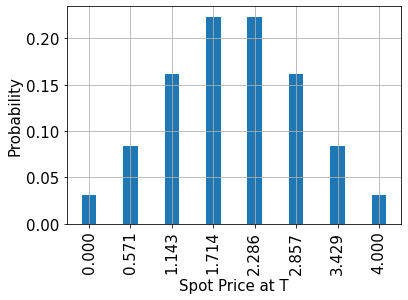

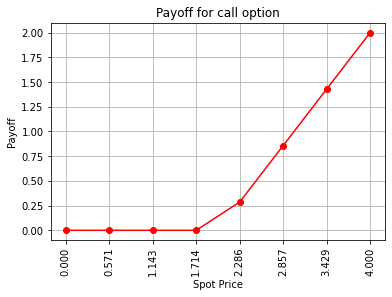

exact expected value:	0.3848
Estimated value:    	0.4045
Confidence interval:	[0.3769, 0.4320]


0.40449227281240296

In [ ]:
uncertainty_model = getuncertainty_model(3, 'normal', mu, sigma, low, high)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
exact_value = get_exact_values(uncertainty_model, x, y, ' call option')
european_call, european_call_objective = getCircuit(uncertainty_model, strike_price, 0.25, low, high,
                                                    [low, strike_price], [0,1], [0,0], 0, high - strike_price)

# set target precision and confidence level
epsilon = 0.01
alpha = 0.05
  
estimatePrice(epsilon, alpha, 500, european_call, european_call_objective)

## Put Option

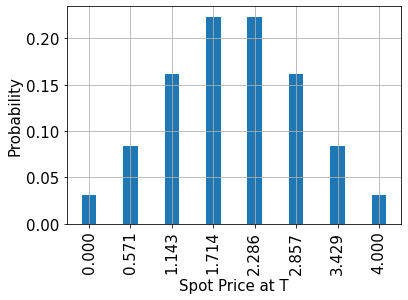

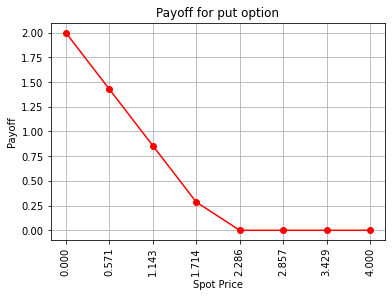

exact expected value:	0.3848
Estimated value:    	0.4047
Confidence interval:	[0.3926, 0.4168]


0.40470426521292613

In [ ]:
uncertainty_model = getuncertainty_model(3, 'normal', mu, sigma, low, high)
x = uncertainty_model.values
y = np.maximum(0, strike_price - x)
exact_value = get_exact_values(uncertainty_model, x, y, ' put option')
european_put, european_put_objective = getCircuit(uncertainty_model, strike_price, 0.25, low, high,
                                [low, strike_price], [-1,0], [strike_price-low,0], 0, strike_price - low)
estimatePrice(epsilon, alpha, 500, european_put, european_put_objective)